In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import numpy as np
import pandas as pd

from random import random, uniform
from io import StringIO

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
datastr = StringIO("""
Pokemon	Label	Level	SpdMod	IngMod	BerMod	SklMod	Ingredients	Berries
Pikachu	08/17 Pikachu Lvl: 13, Spd: +	13	+				2	15
Pikachu	08/25 Pikachu Lvl: 5, Ing: +	5		+			2	13
Pikachu	08/09 Pikachu Lvl: 5, Ing: -, Skl: +	5		-		+	1	15
Pikachu	08/14 Pikachu Lvl: 12, Spd: M, Ing: +	12	M	+			3	16
""")

data = pd.read_csv(datastr, sep='\t', header=0)
data = data.set_index (["Pokemon","Label"])
data = data.fillna("") 
data.sort_index(axis=0, ascending=True, inplace=True)
data.head(30)


data.to_pickle('./data/observations.pickle')
    

Level SpdMod IngMod BerMod  \
Pokemon Label                                                               
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +       5             -          
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +     12      M      +          
        08/17 Pikachu Lvl: 13, Spd: +             13      +                 
        08/25 Pikachu Lvl: 5, Ing: +               5             +          

                                              SklMod  Ingredients  Berries  
Pokemon Label                                                               
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +       +            1       15  
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +                   3       16  
        08/17 Pikachu Lvl: 13, Spd: +                           2       15  
        08/25 Pikachu Lvl: 5, Ing: +                            2       13

In [3]:
def computeBonusAndSpeed(individual, species, output):

    berryBonus = 2.0 if species["Specialty"] == 'Berries' else 1.0
    ingBonus = 2.0 if species["Specialty"] == 'Ingredients' else 1.0
    
    if individual["BerMod"].find("S") > -1: berryBonus += 1.0
    
    output["IngBonus"] = ingBonus
    output["BerryBonus"] = berryBonus
        
    period = species["Period"]
    if individual["SpdMod"].find("S") > -1: period *= 0.93
    if individual["SpdMod"].find("M") > -1: period *= 0.86
    if individual["SpdMod"].find("+") > -1: period *= 0.9
    if individual["SpdMod"].find("-") > -1: period *= 1.1
    period /= (1 + (individual["Level"]-1)*2.0/1000)
    #period = math.floor(period)
    
    output["Period"] = period
    output["Help3h"] = (3*60*60)/period
    

    delta = 0
    d = 1
    if individual["IngMod"].find("+") > -1: delta += d
    if individual["IngMod"].find("-") > -1: delta += -d
    
    output["IngDelta"] = delta
    

In [4]:
def berryCount(help3h, berryBonus, berry_fraction, energy_m):
    return int(round(help3h*berry_fraction*energy_m*berryBonus))

def ingCount(help3h, ingBonus, ingredient_fraction, energy_m):
    return int(round(help3h*ingredient_fraction*energy_m*ingBonus))

def validate(observation, computed, ingredient_fraction, energy_m):
    
    help3h = computed["Help3h"]
    ingBonus = computed["IngBonus"]
    berryBonus = computed["BerryBonus"]
    ingDelta = computed["IngDelta"]
    
    #ingDelta *= 0.04
    ingDelta *= 0.35
       
    berry_fraction = 1 - ingredient_fraction # Needed if renomalization
    
    # A
    ingredient_fraction =  ingredient_fraction * (1 + ingDelta)                    #A1 either
    #ingredient_fraction =  ingredient_fraction + ingDelta                         #A2

 
    #ingredient_fraction = ingredient_fraction/(ingredient_fraction+berry_fraction)  # yes/no

    berry_fraction = 1-ingredient_fraction                                  # Always yes.         

    ing = ingCount(help3h, ingBonus, ingredient_fraction, energy_m)
    ber = berryCount(help3h, berryBonus, berry_fraction, energy_m)
    
    return ing == int(observation["Ingredients"]) and ber == int(observation["Berries"])

In [5]:
pokedex = pd.read_pickle('./data/pokedex.pickle')
pokedex_dict  = pokedex.to_dict(orient='index', index=True)
data_list  = data.reset_index().to_dict(orient='records', index=True)

for individual in data_list:   
    species = pokedex_dict[individual['Pokemon']]
    computeBonusAndSpeed(individual, species, individual)
    
computed = pd.DataFrame.from_records(data_list, index=['Pokemon',"Label"])
computed.sort_index(axis=0, ascending=True, inplace=True)
computed.head(30)

Level SpdMod IngMod BerMod  \
Pokemon Label                                                               
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +       5             -          
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +     12      M      +          
        08/17 Pikachu Lvl: 13, Spd: +             13      +                 
        08/25 Pikachu Lvl: 5, Ing: +               5             +          

                                              SklMod  Ingredients  Berries  \
Pokemon Label                                                                
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +       +            1       15   
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +                   3       16   
        08/17 Pikachu Lvl: 13, Spd: +                           2       15   
        08/25 Pikachu Lvl: 5, Ing: +                            2       13   

                                               IngBonus  BerryBonus  \
Pokemon Label                                                         
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +        1.0         2.0   
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +       1.0         2.0   
        08/17 Pikachu Lvl: 13, Spd: +               1.0         2.0   
        08/25 Pikachu Lvl: 5, Ing: +                1.0         2.0   

                                                    Period    Help3h  IngDelta  
Pokemon Label                                                                   
Pikachu 08/09 Pikachu Lvl: 5, Ing: -, Skl: +   2678.571429  4.032000        -1  
        08/14 Pikachu Lvl: 12, Spd: M, Ing: +  2272.015656  4.753488         1  
        08/17 Pikachu Lvl: 13, Spd: +          2373.046875  4.551111         0  
        08/25 Pikachu Lvl: 5, Ing: +           2678.571429  4.032000         1

In [6]:
computed = computed.reset_index()
#computed["Group"] = computed["Pokemon"]
computed["Group"] = computed["Label"]
computed = computed.set_index(["Group","Label"])
computed.head(5)

,,Pokemon,Level,SpdMod,IngMod,BerMod,SklMod,Ingredients,Berries,IngBonus,BerryBonus,Period,Help3h,IngDelta
Group,Label,,,,,,,,,,,,,
"08/09 Pikachu Lvl: 5, Ing: -, Skl: +","08/09 Pikachu Lvl: 5, Ing: -, Skl: +",Pikachu,5,,-,,+,1,15,1.0,2.0,2678.571429,4.032000,-1
"08/14 Pikachu Lvl: 12, Spd: M, Ing: +","08/14 Pikachu Lvl: 12, Spd: M, Ing: +",Pikachu,12,M,+,,,3,16,1.0,2.0,2272.015656,4.753488,1
"08/17 Pikachu Lvl: 13, Spd: +","08/17 Pikachu Lvl: 13, Spd: +",Pikachu,13,+,,,,2,15,1.0,2.0,2373.046875,4.551111,0
"08/25 Pikachu Lvl: 5, Ing: +","08/25 Pikachu Lvl: 5, Ing: +",Pikachu,5,,+,,,2,13,1.0,2.0,2678.571429,4.032000,1


In [7]:
recompute = True
nb_samples = 100000

if recompute:

    # extract unique group
    group = list(computed.index.get_level_values(0).unique())
    obs_by_spec = dict([(name,computed.loc[name].to_dict(orient='records', index=True)) for name in group])

    # setup storage, list are much faster to grow than dataframe.
    rnd_trials_list = []
    rnd_params_list = []

    for index_trial in range(0,nb_samples):

        ingredient_fraction = uniform(0, 0.4)
        energy_m = uniform(2.0, 2.5)

        results = []

        for name in group:
            
            obs = obs_by_spec[name]
            res = 1.0

            for item in obs:
                
                res *= 1.0 if validate(item,item, ingredient_fraction, energy_m) else 0
                if(res == 0): 
                    break;

            results.append(res)
 
        if(sum(results) == 0): 
            continue

        rnd_trials_list.append(results)
        rnd_params_list.append([ingredient_fraction,energy_m])

        
    #convert list to dataframe
    rnd_trials = pd.DataFrame(rnd_trials_list, columns = group)
    rnd_params = pd.DataFrame(rnd_params_list, columns = ["ingredient%","energy_m"])
    

    rnd_params.to_pickle('./saved/rnd_params.pickle')
    rnd_trials.to_pickle('./saved/rnd_trials.pickle')
    

else:
    
    rnd_params = pd.read_pickle('./saved/rnd_params.pickle')
    rnd_trials = pd.read_pickle('./saved/rnd_trials.pickle')

In [8]:
rnd_trials.describe()
rnd_params.describe()

,"08/09 Pikachu Lvl: 5, Ing: -, Skl: +","08/14 Pikachu Lvl: 12, Spd: M, Ing: +","08/17 Pikachu Lvl: 13, Spd: +","08/25 Pikachu Lvl: 5, Ing: +"
count,15834.000000,15834.000000,15834.000000,15834.000000
mean,0.635215,0.223127,0.324176,0.305608
std,0.481385,0.416356,0.468081,0.460679
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


,ingredient%,energy_m
count,15834.000000,15834.000000
mean,0.192139,2.156491
std,0.037222,0.109333
min,0.093528,2.000005
25%,0.171319,2.066470
50%,0.197245,2.137370
75%,0.218848,2.226604
max,0.262807,2.470685


In [9]:
# Here we enforce that energy_m is shared by all mons.

enforceM = True

if enforceM:

    energy_m_mins = []
    energy_m_maxs = []


    for col in rnd_trials.columns:

        values = rnd_params["energy_m"].loc[rnd_trials[col]==1]
        energy_m_mins.append(values.min())
        energy_m_maxs.append(values.max())

    low = max(energy_m_mins)
    high = min(energy_m_maxs)


    valid = rnd_params["energy_m"].between(low, high)
    rnd_trials = rnd_trials.loc[valid]
    rnd_params = rnd_params.loc[valid]

    (low,high)



(2.159305213408277, 2.249093544278284)

In [10]:
def get_valid_params(cols):

    df = rnd_trials[cols].copy()
    df = df.loc[(df!=0).all(axis=1)]
    return rnd_params.loc[df.index]


In [11]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def plot_hull(df, ax, name, **kwargs):
    
    points = df[["ingredient%", "energy_m"]].to_numpy()
    hull = ConvexHull(points)
    hullpts = points[hull.vertices,:]
    
    patch = Polygon(hullpts, closed=True, label=name, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    ax.add_collection(collection, autolim=True)
    
    return patch
    

In [12]:
def plot_group(cols, samples=None):
    
    if(samples is None):
        samples = get_valid_params(cols)
    
    # Standard scale to compare cluster.
    
    fig, ax = plt.subplots()
    #sns.scatterplot(data=samples,y="energy_m", x="ingredient%", alpha=0.8, ax=ax)
    plt.xlabel("Ingredient %",fontweight ='bold', size=14)
    plt.ylabel("Production Boost (M)", fontweight ='bold',size=14)
    name = " ".join(cols)
    plt.title(name)
    ax.set_xlim(0, 0.4)
    ax.set_ylim(2.16, 2.25)
    
    _ = plot_hull(pts,ax, name, alpha=0.8)
    
    display(fig)
    plt.close()


,ingredient%,energy_m
count,2756.000000,2756.000000
mean,0.226017,2.196590
std,0.021328,0.024641
min,0.170740,2.159305
25%,0.210617,2.175696
50%,0.228093,2.193276
75%,0.243736,2.215634
max,0.262807,2.249094


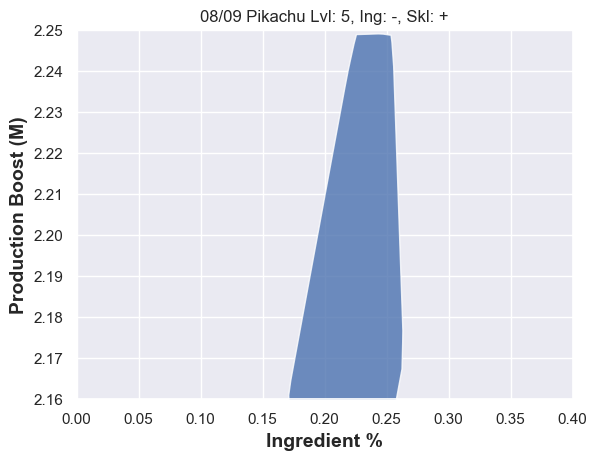

,ingredient%,energy_m
count,731.000000,731.000000
mean,0.185844,2.217961
std,0.006416,0.022317
min,0.173575,2.159305
25%,0.180812,2.200496
50%,0.185317,2.222759
75%,0.190268,2.236432
max,0.203069,2.249031


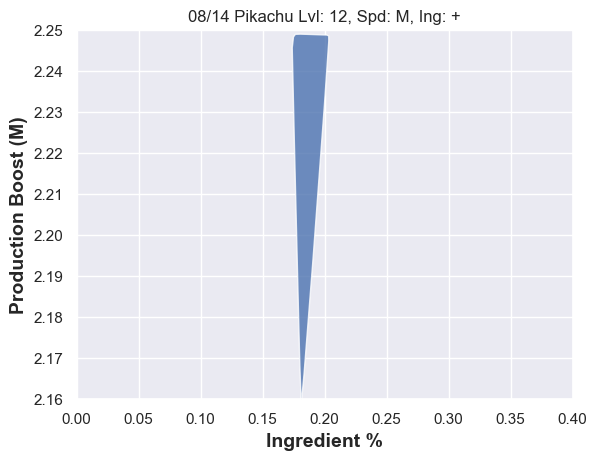

,ingredient%,energy_m
count,986.000000,986.000000
mean,0.237024,2.190434
std,0.009118,0.021863
min,0.213779,2.159311
25%,0.230419,2.171977
50%,0.238547,2.187021
75%,0.244189,2.205643
max,0.254155,2.249094


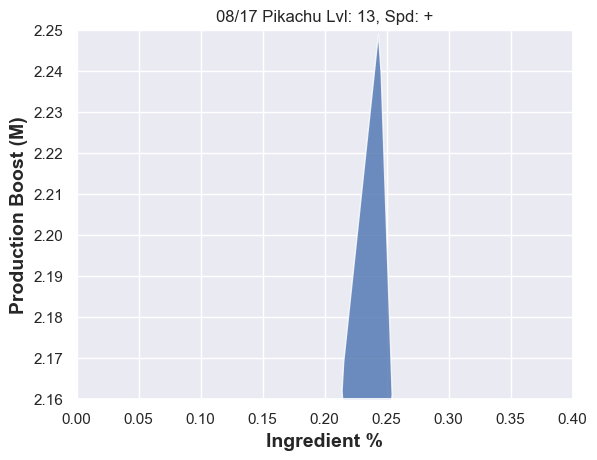

,ingredient%,energy_m
count,1366.000000,1366.000000
mean,0.192089,2.196760
std,0.010261,0.024777
min,0.166773,2.159305
25%,0.184748,2.175878
50%,0.192545,2.193432
75%,0.200475,2.216186
max,0.211036,2.248812


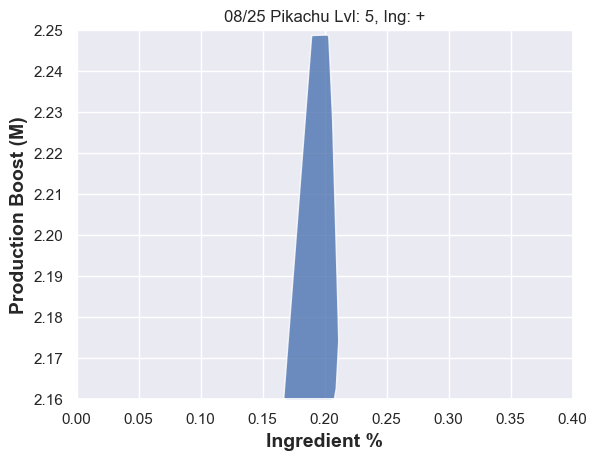

In [13]:
# Display individual Pokémon

all_portraits = []

for col in rnd_trials.columns:
    pts = get_valid_params([col]).copy()
    display(pts.describe())
    plot_group([col],pts)
    pts["group"] = col
    all_portraits.append(pts)



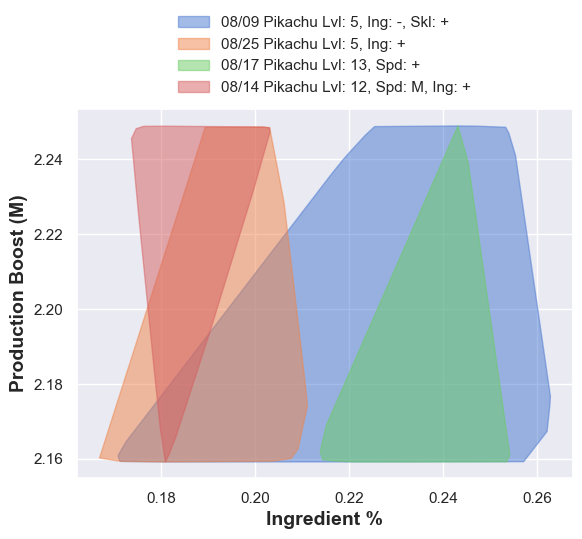

In [14]:
allpts = sorted(all_portraits, key=lambda x: -len(x.index)) 

fig, ax = plt.subplots()
_ = plt.xlabel("Ingredient %",fontweight ='bold', size=14);
_ = plt.ylabel("Production Boost (M)", fontweight ='bold',size=14);

handles, labels = plt.gca().get_legend_handles_labels()
palette = sns.color_palette(palette="muted", n_colors=8)
cidx = 0;

for pts in allpts:
    p = plot_hull(pts, ax, pts["group"].iloc[0], alpha=0.5, color = palette[cidx])
    cidx += 1
    handles.extend([p])

ax.autoscale()

_ = plt.legend(handles=handles)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=False,
)

display(fig)
plt.close()

In [15]:
"""
Pokemon	Label	Level	SpdMod	IngMod	BerMod	SklMod	Ingredients	Berries
Pikachu	08/17 Pikachu Lvl: 13, Spd: +	13	+				2	15
Pikachu	08/25 Pikachu Lvl: 5, Ing: +	5		+			2	13
Pikachu	08/09 Pikachu Lvl: 5, Ing: -, Skl: +	5		-		+	1	15
Pikachu	08/14 Pikachu Lvl: 12, Spd: M, Ing: +	12	M	+			3	16
"""

"""
Pokemon	Label	Level	SpdMod	IngMod	BerMod	SklMod	Ingredients	Berries
Charmander	08/14 Charmander Lvl: 9, Spd: +	9	+				3	6
Charmander	08/25 Charmander Lvl: 8, Ing: -, Skl: +	8		-		+	2	6
"""

"""
Pokemon	Label	Level	SpdMod	IngMod	BerMod	SklMod	Ingredients	Berries
Mankey	08/11 Mankey Lvl: 10	10					1	9
Mankey	08/14 Mankey Lvl: 6, Ing: -, Skl: +	6		-		+	1	10
"""

"""
Chikorita	08/08 Chikorita Lvl: 10, Ber: S, Skl: -	10			S	-	1	14
Chikorita	08/14 Chikorita Lvl: 6, Ing: -	6		-			1	10
"""


'\nPokemon\tLabel\tLevel\tSpdMod\tIngMod\tBerMod\tSklMod\tIngredients\tBerries\nPikachu\t08/17 Pikachu Lvl: 13, Spd: +\t13\t+\t\t\t\t2\t15\nPikachu\t08/25 Pikachu Lvl: 5, Ing: +\t5\t\t+\t\t\t2\t13\nPikachu\t08/09 Pikachu Lvl: 5, Ing: -, Skl: +\t5\t\t-\t\t+\t1\t15\nPikachu\t08/14 Pikachu Lvl: 12, Spd: M, Ing: +\t12\tM\t+\t\t\t3\t16\n'

'\nPokemon\tLabel\tLevel\tSpdMod\tIngMod\tBerMod\tSklMod\tIngredients\tBerries\nCharmander\t08/14 Charmander Lvl: 9, Spd: +\t9\t+\t\t\t\t3\t6\nCharmander\t08/25 Charmander Lvl: 8, Ing: -, Skl: +\t8\t\t-\t\t+\t2\t6\n'

'\nPokemon\tLabel\tLevel\tSpdMod\tIngMod\tBerMod\tSklMod\tIngredients\tBerries\nMankey\t08/11 Mankey Lvl: 10\t10\t\t\t\t\t1\t9\nMankey\t08/14 Mankey Lvl: 6, Ing: -, Skl: +\t6\t\t-\t\t+\t1\t10\n'

'\nChikorita\t08/08 Chikorita Lvl: 10, Ber: S, Skl: -\t10\t\t\tS\t-\t1\t14\nChikorita\t08/14 Chikorita Lvl: 6, Ing: -\t6\t\t-\t\t\t1\t10\n'